In [129]:
%matplotlib inline
from IPython.display import IFrame

### usual imports

In [130]:
import os
import sys
from glob import glob 

In [131]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

### fbprophet 

[fbprophet](https://facebook.github.io/prophet/) implement a [Generalized Additive Model](https://en.wikipedia.org/wiki/Generalized_additive_model) in Python and R, and is extremely convenient for the modelling of time-series which contain a **trend** (potentially non-linear), some **cyclic components** (e.g. seasonal cycle, weekly cycle, daily cycle, ...) and potentially responds
to **`pulse` events** which do not obey a regular schedule, the latter is particularly important for e.g. time-series of sales data, where holidays, special events, marketing campains, etc, might drive short term, irregular increases or decrease in sales volume / value.   

And of course, of interest for us is the fact that you can easily add **extra regressors** to the model: in our case it is likely to be climate / weather variables, and the formulation of the model makes is relatively easy to quantify the added value derived from incorporating climate / weather explanatory variables to the model.

to know more about the **Generalized Additive Model** framework, a good start is:   
    
[https://multithreaded.stitchfix.com/assets/files/gam.pdf](https://multithreaded.stitchfix.com/assets/files/gam.pdf)

and below is the **fbprophet** website, I strongly recommend reading the paper, which is very well written and clear

In [396]:
IFrame(src='https://facebook.github.io/prophet/', width=1500, height=600)

### import fbprophet 

In [258]:
from fbprophet import Prophet

### scikit learn Mean Absolute Error metrics function (MAE)

In [259]:
from sklearn.metrics import mean_absolute_error as MAE

### seaborn for visualisation 

In [260]:
import seaborn as sns

### read the data: cycling counts over Tamaki drive 

the data is taken from [https://awcc.mrcagney.works/](https://awcc.mrcagney.works/)

In [261]:
from IPython.display import IFrame

In [271]:
IFrame(src='https://awcc.mrcagney.works/', width='90%', height=600)

### for a slightly more convenient view of the location of the counters, we're gonna create an interactive map in the Jupyter Notebook using [https://github.com/python-visualization/folium](https://github.com/python-visualization/folium)

#### reads in the locations of the counters 

In [397]:
loc_counters = pd.read_csv('../data/cycling_Auckland/cycling_counters.csv')

In [398]:
loc_counters.head()

#### we're only keeping the counters for cyclists

In [399]:
loc_counters = loc_counters.query("user_type == 'Cyclists'")

### we're gonna centre the map on the Tamaki Drive counter 

In [400]:
loc_counters.query("name == 'Tamaki Drive EB'")

In [401]:
center_lat = loc_counters.query("name == 'Tamaki Drive EB'").latitude.values[0]
center_lon = loc_counters.query("name == 'Tamaki Drive EB'").longitude.values[0]

### display the counters locations on an interactive map

In [402]:
import folium
from folium.plugins import MarkerCluster

In [403]:
folium.__version__

'0.5.0+146.g41e494d'

this is the development version of folium

In [406]:
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=15,
    tiles='OpenStreetMap', 
    width='80%', 
)

m.add_child(folium.LatLngPopup())

# marker_cluster = MarkerCluster().add_to(m)

# loops over each row in the DataFrame holding the counters information, and 
# adds to the map 

for i, row in loc_counters.iterrows():
    name = row['name']
    lat = row.latitude
    lon = row.longitude
    opened = row.setup_date
    
    # HTML here in the pop up 
    popup = '<b>{}</b></br><i>setup date = {}</i>'.format(name, opened)
    
#     folium.Marker([lat, lon], popup='<i>{}</i>'.format(name), tooltip=name).add_to(marker_cluster)
    folium.Marker([lat, lon], popup=popup, tooltip=name).add_to(m)

### now display the map, centered on the Tamaki drive counters 

In [408]:
m

### now reads the cycling counts

#### get the list of files (one per year)

In [409]:
lfiles = glob('../data/cycling_Auckland/cycling_counts_????.csv')

#### sort

In [410]:
lfiles.sort()

In [411]:
lfiles

['../data/cycling_Auckland/cycling_counts_2010.csv',
 '../data/cycling_Auckland/cycling_counts_2011.csv',
 '../data/cycling_Auckland/cycling_counts_2012.csv',
 '../data/cycling_Auckland/cycling_counts_2013.csv',
 '../data/cycling_Auckland/cycling_counts_2014.csv',
 '../data/cycling_Auckland/cycling_counts_2015.csv',
 '../data/cycling_Auckland/cycling_counts_2016.csv',
 '../data/cycling_Auckland/cycling_counts_2017.csv',
 '../data/cycling_Auckland/cycling_counts_2018.csv']

#### loops over the list of files, reads and keep the Tamaki Drive data, and concatenate 

In [412]:
l = []
for f in lfiles: 
    d = pd.read_csv(f, index_col=0, parse_dates=True, usecols=['datetime', 'Tamaki Drive EB','Tamaki Drive WB'])
    l.append(d)

In [413]:
df = pd.concat(l, axis=0)

In [414]:
df.head()

In [415]:
df.tail()

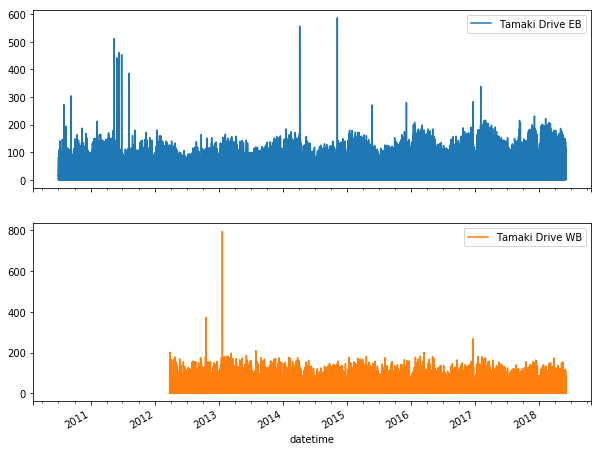

In [416]:
df.plot(subplots=True, figsize=(10, 8));

### seasonal cycle (30 days running window for smoothing) 

Text(0.5,0,'day of year')

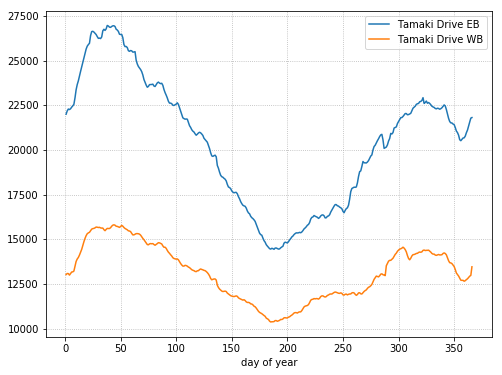

In [417]:
f, ax = plt.subplots(figsize=(8,6)) 
df.rolling(window=30*24, center=True).sum().groupby(df.index.dayofyear).mean().plot(ax=ax)
ax.grid(ls=':')
ax.set_xlabel('day of year')

### weekly cycle 

Text(0.5,0,'day of week')

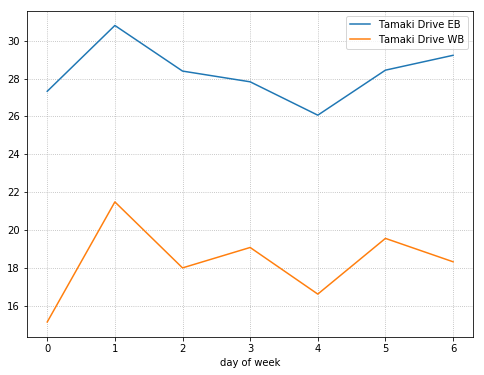

In [418]:
f, ax = plt.subplots(figsize=(8,6)) 
df.groupby(df.index.dayofweek).mean().plot(ax=ax)
ax.grid(ls=':')
ax.set_xlabel('day of week')

### daily cycle 

In [419]:
summary_hour = df.groupby(df.index.hour).describe()

In [420]:
summary_hour.head()

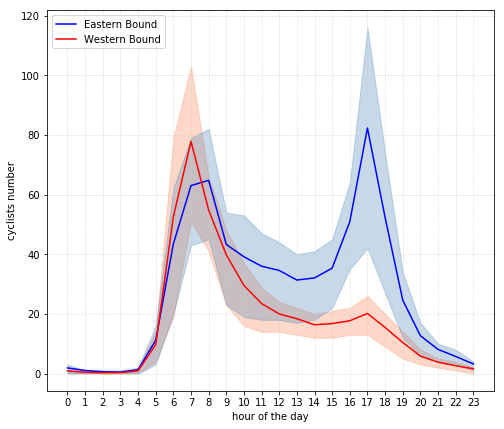

In [421]:
f, ax = plt.subplots(figsize=(8,7))

ax.plot(summary_hour.index, summary_hour.loc[:,('Tamaki Drive EB','mean')], color='b', label='Eastern Bound')
ax.plot(summary_hour.index, summary_hour.loc[:,('Tamaki Drive WB','mean')], color='r', label='Western Bound')

ax.fill_between(summary_hour.index, summary_hour.loc[:,('Tamaki Drive WB','25%')], \
                summary_hour.loc[:,('Tamaki Drive WB','75%')], color='coral', alpha=0.3)

ax.fill_between(summary_hour.index, summary_hour.loc[:,('Tamaki Drive EB','25%')], \
                summary_hour.loc[:,('Tamaki Drive EB','75%')], color='steelblue', alpha=0.3)

ax.legend(loc=2)

ax.set_xticks(range(24));
ax.grid(ls=':', color='0.8')

ax.set_xlabel('hour of the day')

ax.set_ylabel('cyclists number');

### getting rid of the outliers using a median filter 

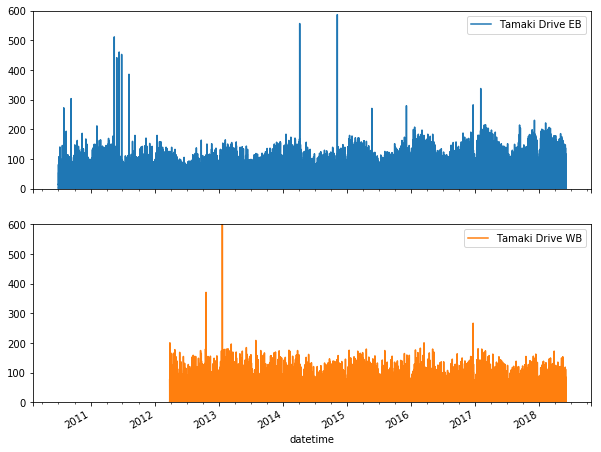

In [294]:
df.plot(subplots=True, figsize=(10, 8), **{'ylim':[0, 600]});

In [301]:
def median_filter(df, varname = 'Tamaki Drive EB', window=24, std=2): 
    
    dfc = df.copy() 
    
    dfc = dfc.loc[:,[varname]]
    
    dfc['median']= dfc[varname].rolling(window, center=True).median()
    
    dfc['std'] = dfc[varname].rolling(window, center=True).std()
    
    dfc.loc[dfc.loc[:,varname] >= dfc['median']+std*dfc['std'], varname] = np.nan
    
    dfc.loc[dfc.loc[:,varname] <= dfc['median']-std*dfc['std'], varname] = np.nan
    
    return dfc.loc[:, varname]

In [302]:
df_filtered = df.copy()

In [303]:
varname = 'Tamaki Drive EB'

In [304]:
df_filtered.loc[:,varname] = median_filter(df_filtered, varname = varname)

In [305]:
varname = 'Tamaki Drive WB'

In [306]:
df_filtered.loc[:,varname] = median_filter(df_filtered, varname = varname)

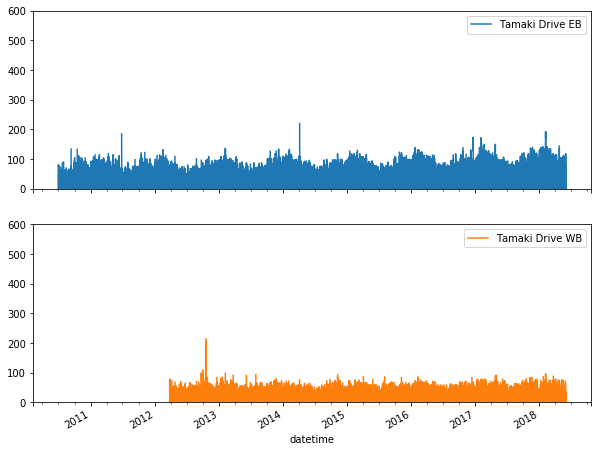

In [307]:
df_filtered.plot(subplots=True, figsize=(10, 8), **{'ylim':[0, 600]});

### resampling at the daily time-step


In [308]:
df_filtered = df_filtered.resample('1D').sum()

In [309]:
df_filtered.head()

In [310]:
df_filtered.tail()

### we're gonna look at the cyclists count for Eastern Bound Tamaki Drive ... starting in 2011 as it is when the climate data starts

In [311]:
data = df_filtered.loc['2011':,['Tamaki Drive EB']]

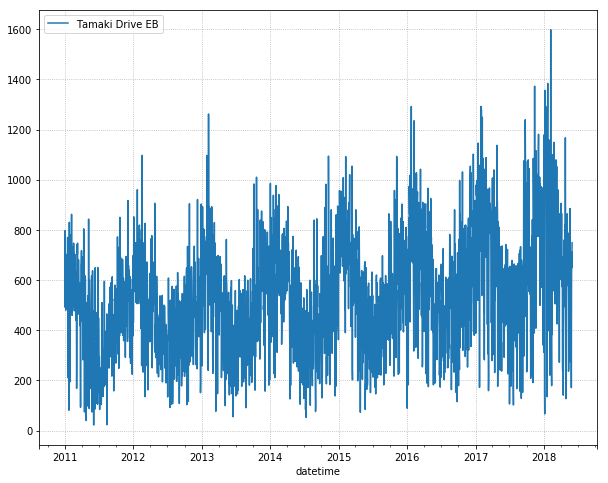

In [312]:
f, ax = plt.subplots(figsize=(10,8))
data.plot(ax=ax)
ax.grid(ls=':')
f.savefig('../figures/cycling_counts_Tamaki_drive_EB.png', dpi=200)

### preparing the data 

In [313]:
data = data.rename({'Tamaki Drive EB':'y'}, axis=1)

In [314]:
data.tail()

### defining here a few utility functions to do all the 'data wrangling'

In [315]:
def add_regressor(data, regressor, varname=None): 
    
    """
    adds a regressor to a dataframe of targets
    """
    
    data.loc[:,varname] = regressor.loc[:,varname]
    
    return data

In [316]:
def prepare_data(data, year=2017): 
    
    """
    prepare the data for ingestion by fbprophet: 
    
    1) divide in training and test set, using the `year` parameter (int)
    
    2) reset the index and rename the `datetime` column to `ds`
    
    returns the training and test dataframes
    """
    
    
    data_train = data.loc[:str(year - 1),:]
    
    data_test = data.loc[str(year):,:]
    
    data_train.reset_index(inplace=True)
    
    data_test.reset_index(inplace=True)
    
    data_train = data_train.rename({'datetime':'ds'}, axis=1)
    
    data_test = data_test.rename({'datetime':'ds'}, axis=1)
    
    return data_train, data_test

In [317]:
def make_verif(forecast, data_train, data_test): 
    """
    put together the forecast (coming from fbprophet) 
    and the overved data, and set the index to be a proper datetime index, 
    for plotting
    
    """
    
    forecast.index = pd.to_datetime(forecast.ds)
    
    data_train.index = pd.to_datetime(data_train.ds)
    
    data_test.index = pd.to_datetime(data_test.ds)
    
    data = pd.concat([data_train, data_test], axis=0)
    
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

In [318]:
def plot_verif(verif, year=2017):
    """
    plots the forecasts and observed data, the year parameters is used to highlight 
    the difference between the training and test data 
    """
    
    f, ax = plt.subplots(figsize=(10, 8))
    
    train = verif.loc[:str(year - 1),:]
    
    ax.plot(train.index, train.y, 'ko', markersize=3)
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
    
    ax.plot(test.index, test.y, 'ro', markersize=3)
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f

In [319]:
def plot_verif_component(verif, component='rain', year=2017): 
    """
    plots a specific component of the model
    """
    
    f, ax = plt.subplots(figsize=(10, 8))
    
    train = verif.loc[:str(year - 1),:]
        
    ax.plot(train.index, train.loc[:,component], color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.loc[:, component+'_lower'], train.loc[:, component+'_upper'], color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
        
    ax.plot(test.index, test.loc[:,component], color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.loc[:, component+'_lower'], test.loc[:, component+'_upper'], color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f

In [320]:
def add_regressor_to_future(future, regressors_list): 
    """
    adds extra regressors to a `future` dataframe created by fbprophet
    """
    
    futures = future.copy() 
    
    futures.index = pd.to_datetime(futures.ds)
    
    regressors = pd.concat(regressors_list, axis=1)
    
    futures = futures.merge(regressors, left_index=True, right_index=True)
    
    futures = futures.reset_index(drop = True) 
    
    return futures

### splits the data into a training and test set, and returns these data frames in a format **fbprophet** can understand 

In [321]:
data_train, data_test = prepare_data(data, 2017)

In [322]:
data_train.head()

In [323]:
data_test.head()

### instantiates, then fit the model to the training data 

The first step in **fbprophet** is to instantiate the model, it is there that you can set the `prior scales` for each component of your time-series, as well as the number of Fourier series to use to model the cyclic components.   

A general rule is that larger prior scales and larger number of Fourier series will make the model more flexible, but at the potential cost of generalisation: i.e. the model might [overfit](https://en.wikipedia.org/wiki/Overfitting), learning the noise (rather than the signal) in the training data, but 
    giving poor results when applied to yet unseen data (the test data)... setting these [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) can be more an art than a science ... 

In [324]:
m = Prophet(mcmc_samples=300, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [325]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


### make the `future` dataframe 

In [326]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [327]:
future.head()

In [328]:
future.tail()

In [329]:
forecast = m.predict(future)

### plots the `components` of the forecast (trend + cyclic component [yearly seasonality, weekly seasonality] at this stage)

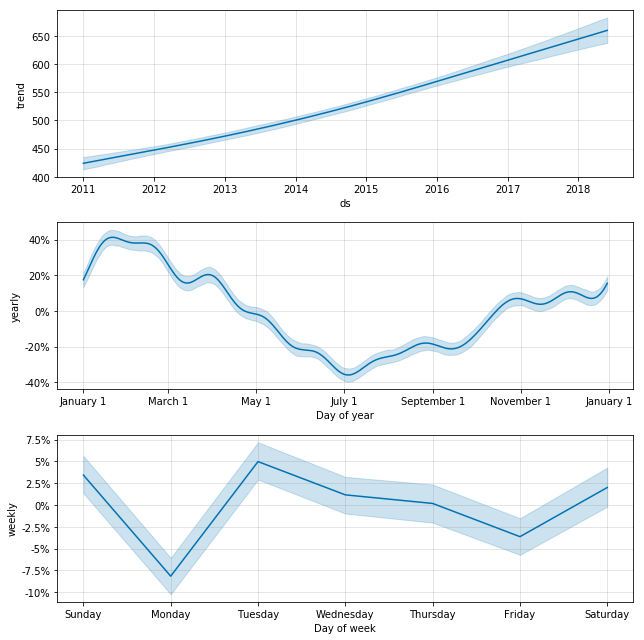

In [330]:
f = m.plot_components(forecast)

### put it all together with the actual observations 

In [331]:
verif = make_verif(forecast, data_train, data_test)

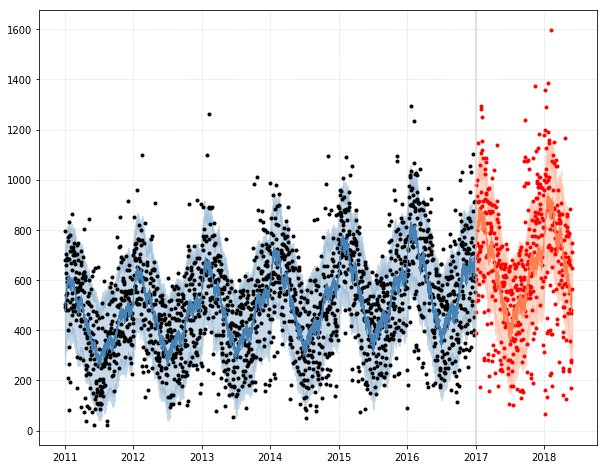

In [332]:
f = plot_verif(verif)

### scatter plot, marginal distribution and correlation between observations and modelled / predicted values 

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


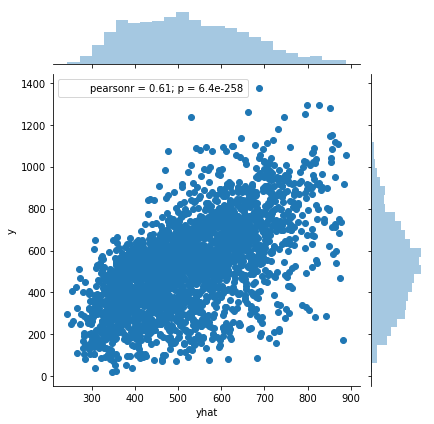

In [333]:
sns.jointplot(x='yhat', y='y', data = verif.loc[:'2017',:]);

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


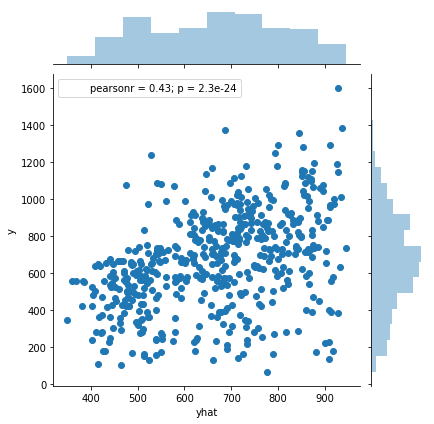

In [334]:
sns.jointplot(x='yhat', y='y', data = verif.loc['2017':,:])

### Mean Absolute Error (in number of cyclists)

In [335]:
MAE(verif.y.values, verif.yhat.values)

137.5456648762583

## now incorporating the effects of the holidays 

In [336]:
holidays_calendar = pd.read_csv('../data/holidays_calendars_2011_2018.csv')

In [337]:
holidays_calendar.loc[:,'ISO_date'] = pd.to_datetime(holidays_calendar.loc[:,'ISO_date'], dayfirst=True)

In [338]:
holidays_calendar = holidays_calendar.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [339]:
holidays_calendar = holidays_calendar.loc[-holidays_calendar.notes.str.contains('Not a public'),:]

In [340]:
holidays = holidays_calendar.loc[(holidays_calendar.loc[:,'Regional'] == 0) | holidays_calendar.RGR.str.contains('Auckland'),:]

In [341]:
holtype = 'category'

In [342]:
if holtype == 'category': 
    holidays = holidays.loc[:,['ISO_date','holiday_category']]
    holidays = holidays.rename({'holiday_category':'holiday'}, axis=1)
if holtype == 'code': 
    holidays = holidays.loc[:,['ISO_date','holiday_code']]
    holidays = holidays.rename({'holiday_code':'holiday'}, axis=1)
else: 
    holidays = holidays.loc[:,['ISO_date','holiday']]

In [343]:
holidays = holidays.rename({'ISO_date':'ds'}, axis=1)

In [344]:
holidays.tail()

In [345]:
m = Prophet(mcmc_samples=300, holidays=holidays, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [346]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/fbprophet-0.3.post2-py3.6.egg/fbprophet/forecaster.py:253: FutureWarning: 'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df = df.sort_values('ds')
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [347]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [348]:
forecast = m.predict(future)

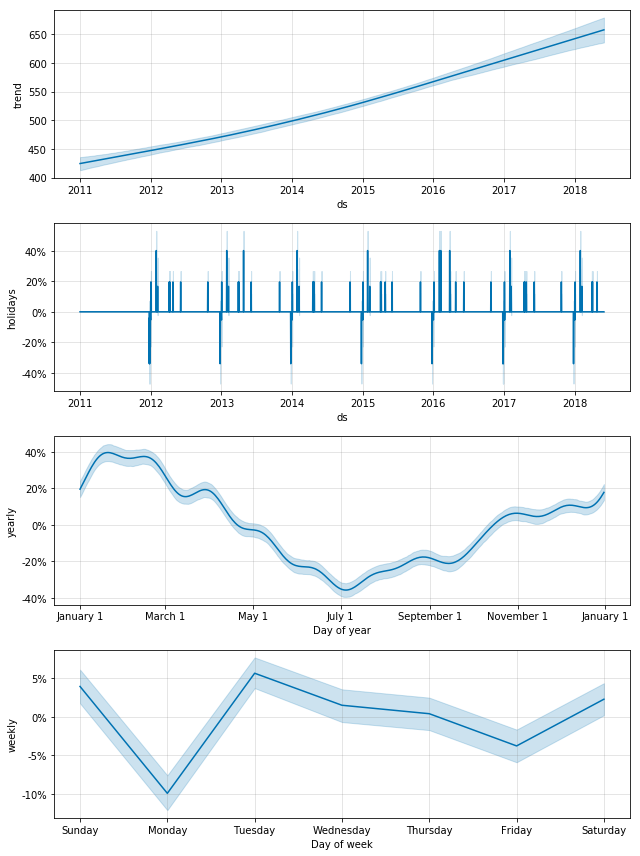

In [349]:
f = m.plot_components(forecast)

In [350]:
verif = make_verif(forecast, data_train, data_test)

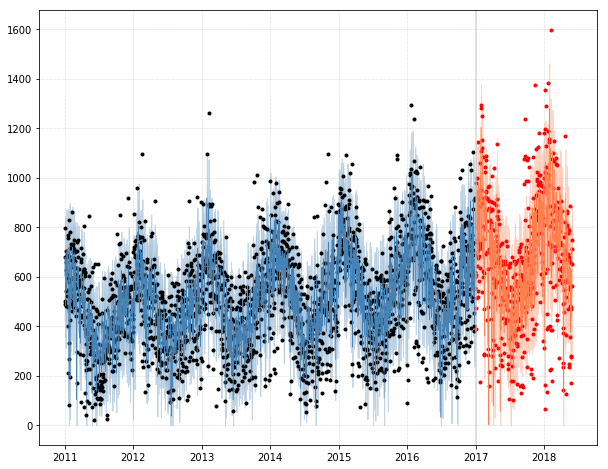

In [385]:
f = plot_verif(verif)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


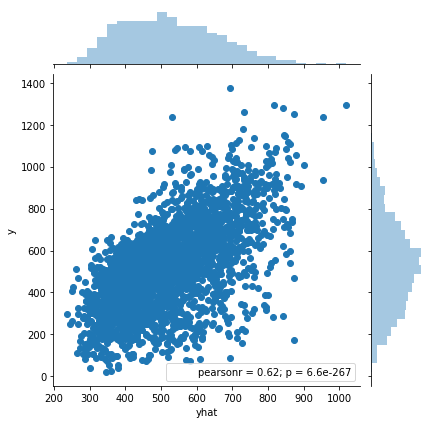

In [352]:
sns.jointplot(x='yhat', y='y', data = verif.loc[:'2017',:])

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


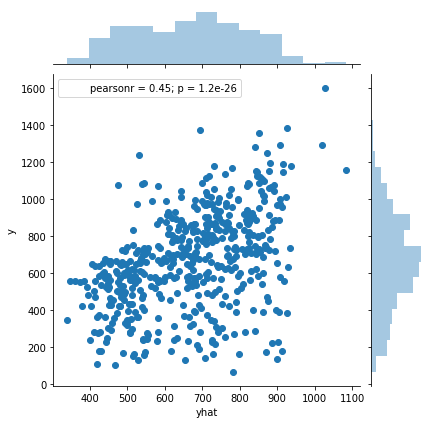

In [353]:
sns.jointplot(x='yhat', y='y', data = verif.loc['2017':,:])

In [354]:
MAE(verif.y.values, verif.yhat.values)

136.59143535067832

## incorporating the effects of weather conditions

In [355]:
temp = pd.read_csv('../data/weather/Mangere_EWS_temp.csv', index_col=0, parse_dates=True)

In [356]:
rain = pd.read_csv('../data/weather/Mangere_EWS_rain.csv', index_col=0, parse_dates=True)

In [357]:
sun = pd.read_csv('../data/weather/Mangere_EWS_sun.csv', index_col=0, parse_dates=True)

### interpolate so that there are no missing values 

In [358]:
temp = temp.interpolate(method='linear')

In [359]:
rain = rain.interpolate(method='linear')

In [360]:
sun = sun.interpolate(method='linear')

### adds the climate regressors to the data 

In [361]:
data_with_regressors = add_regressor(data, temp, varname='temp')

In [362]:
data_with_regressors = add_regressor(data_with_regressors, rain, varname='rain')

In [363]:
data_with_regressors = add_regressor(data_with_regressors, sun, varname='sun')

In [364]:
data_with_regressors.head()

In [365]:
data_with_regressors.tail()

### prepare the data and subsets (train and test set)

In [422]:
data_train, data_test = prepare_data(data_with_regressors, 2017)

In [423]:
m = Prophet(mcmc_samples=300, holidays=holidays, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [424]:
m.add_regressor('temp', prior_scale=1, mode='multiplicative')
m.add_regressor('rain', prior_scale=1, mode='multiplicative')
m.add_regressor('sun', prior_scale=1, mode='multiplicative')

In [425]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [426]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [427]:
futures = add_regressor_to_future(future, [temp, rain, sun])

In [428]:
forecast = m.predict(futures)

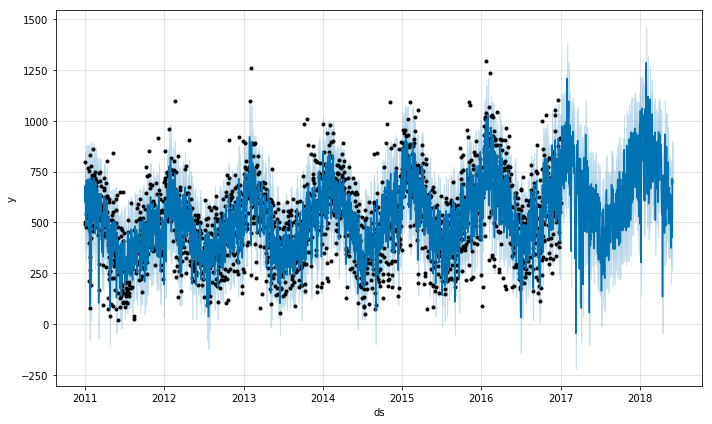

In [429]:
f = m.plot(forecast)

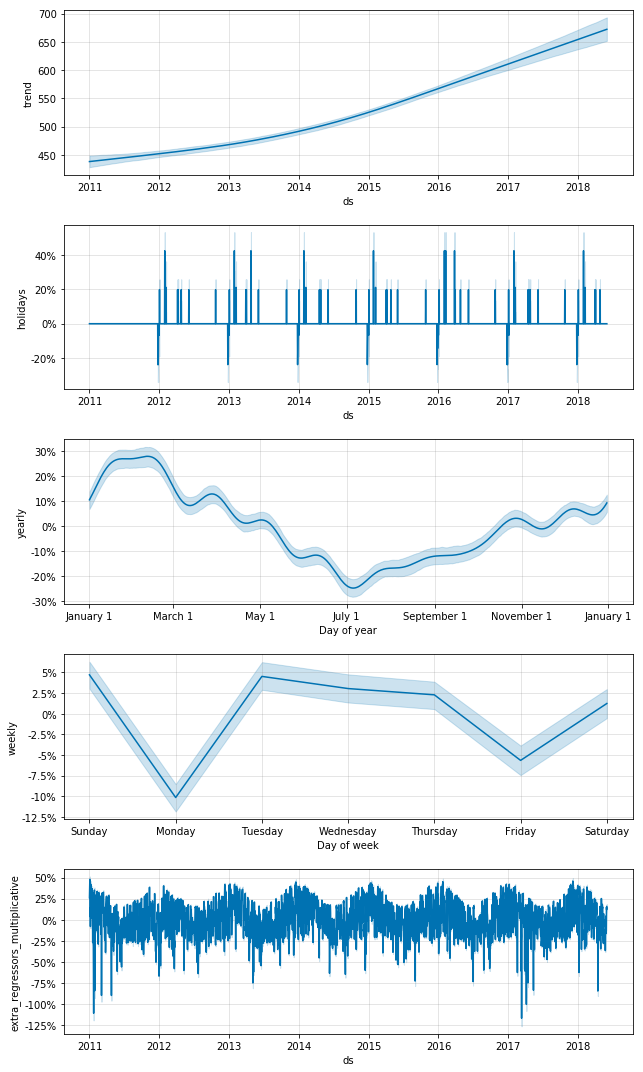

In [430]:
f = m.plot_components(forecast)

Text(0.5,0,'day of week')

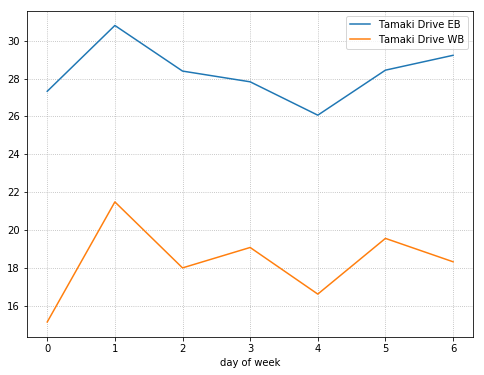

In [431]:
f, ax = plt.subplots(figsize=(8,6)) 
df.groupby(df.index.dayofweek).mean().plot(ax=ax)
ax.grid(ls=':')
ax.set_xlabel('day of week')

In [432]:
verif = make_verif(forecast, data_train, data_test)

In [433]:
verif.head()

In [434]:
verif.loc[:,'yhat'] = verif.yhat.clip_lower(0)

In [435]:
verif.loc[:,'yhat_lower'] = verif.yhat_lower.clip_lower(0)

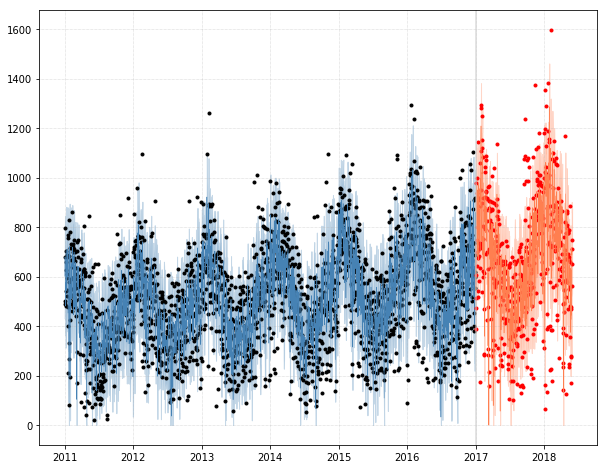

In [436]:
f =  plot_verif(verif)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


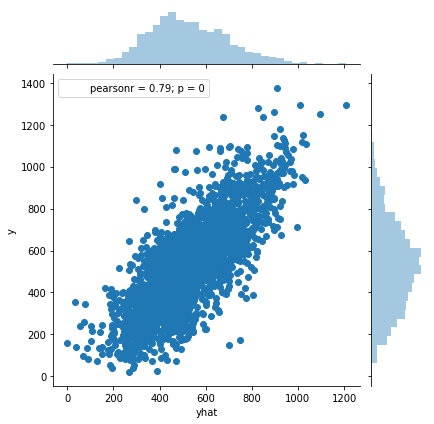

In [437]:
sns.jointplot(x='yhat', y='y', data = verif.loc[:'2017',:])

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


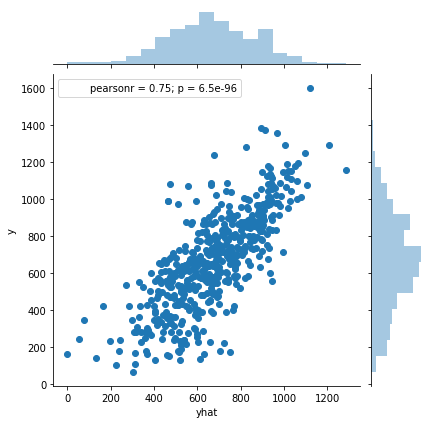

In [438]:
f = sns.jointplot(x='yhat', y='y', data = verif.loc['2017':])
plt.savefig('../figures/joint_plot_climate.png', dpi=200)

### Mean Absolute Error 

In [439]:
MAE(verif.y.values, verif.yhat.values)

105.02690928650625

### plot the contribution of the different climate variables to the response variable (in percentage of the trend component, as we chose a multiplicative model)

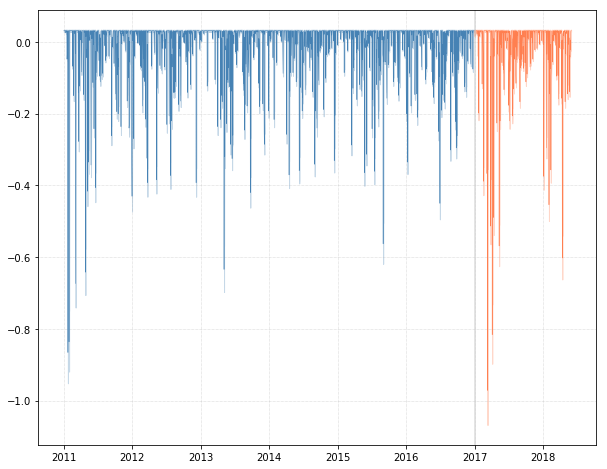

In [440]:
f = plot_verif_component(verif, component = 'rain')

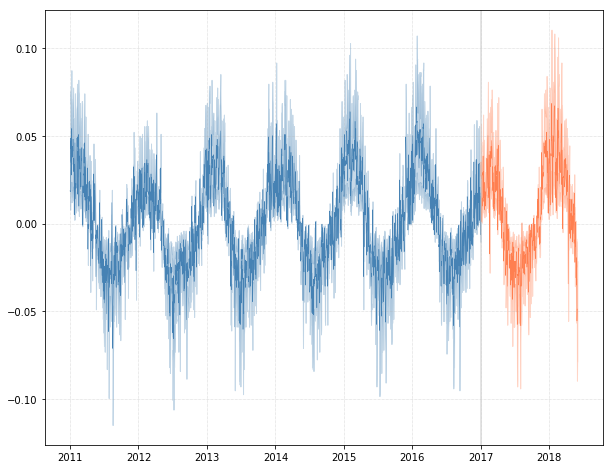

In [441]:
f = plot_verif_component(verif, component = 'temp')

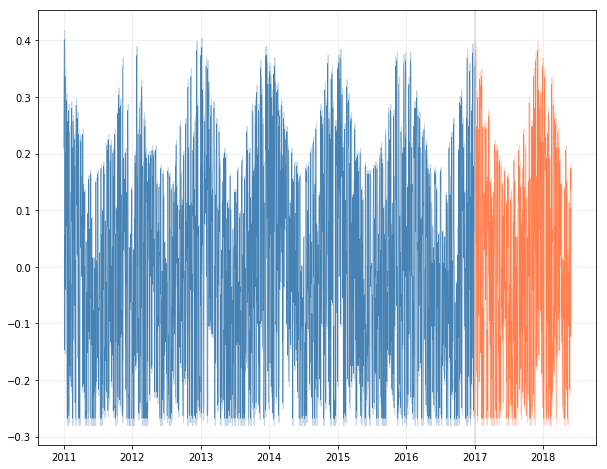

In [442]:
f  = plot_verif_component(verif, component = 'sun')

### plots the combined contribution of the climate extra-regressors

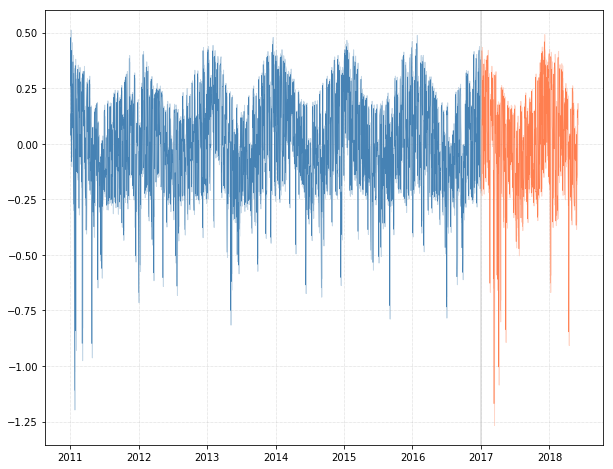

In [443]:
f = plot_verif_component(verif, component = 'extra_regressors_multiplicative')

### zoom in on the post 2016 period (test set)

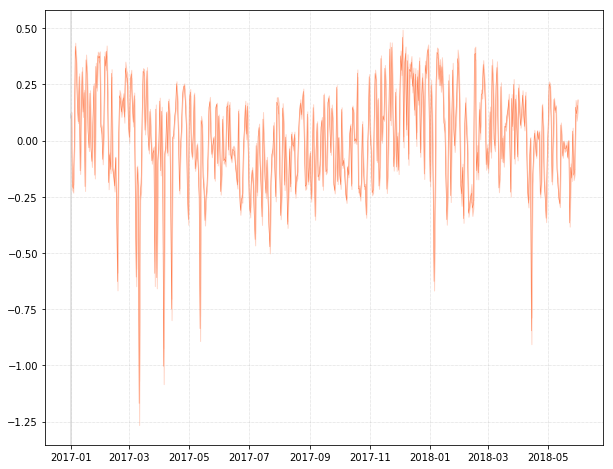

In [444]:
f = plot_verif_component(verif.loc['2016-12-31':,:], component = 'extra_regressors_multiplicative')

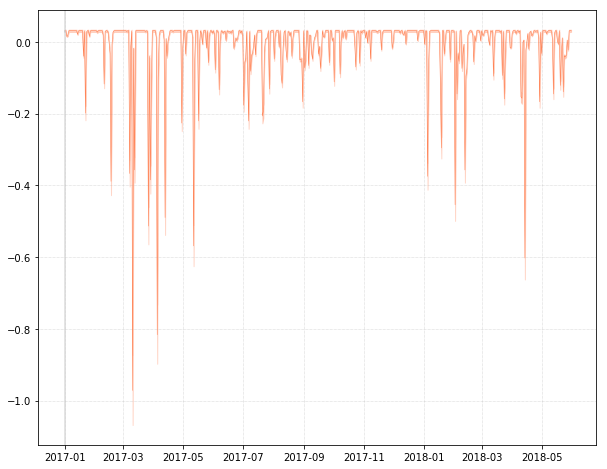

In [445]:
f = plot_verif_component(verif.loc['2016-12-31':,:], component = 'rain')

### plots the forecasts (`yhat`, orange line) and the observed values (`y`, blue line) for the first 4 months of 2017

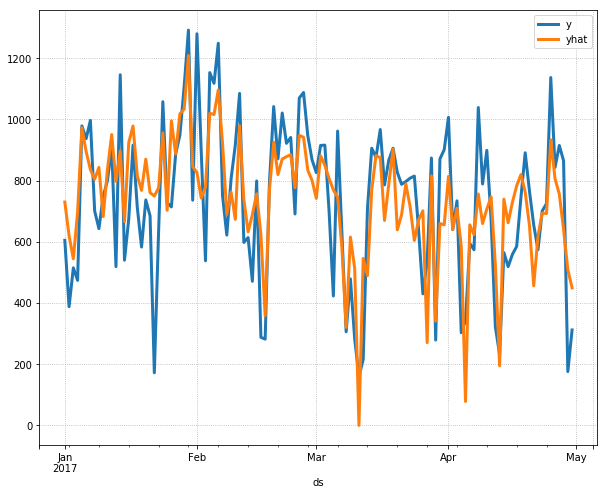

In [446]:
f, ax = plt.subplots(figsize=(10,8))
verif.loc['2017-01-01':'2017-04-30',['y','yhat']].plot(lw=3, ax=ax)
ax.grid(ls=':')
f.savefig('../figures/forecasts_obs_2017-04.png', dpi=200)

### running correlations (over 90 days) between observed and modelled / predicted values, useful to identify when things go South

In [447]:
corr = verif.loc[:,['y','yhat']].rolling(window=90).corr().iloc[0::2,1]

In [448]:
corr.index = corr.index.droplevel(1)

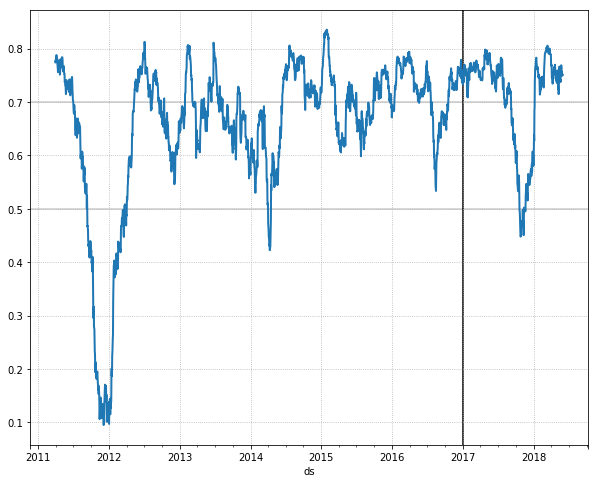

In [449]:
f, ax = plt.subplots(figsize=(10, 8))
corr.plot(ax=ax, lw=2)
ax.axhline(0.7, color='0.8', zorder=-1)
ax.axhline(0.5, color='0.8', zorder=-1)
ax.axvline('2017', color='k', zorder=-1)
ax.grid(ls=':')